In [1]:
import sys
import time
import random
from collections import deque
import collections
import itertools

import daft
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import networkx as nx
import seaborn as sns
import torch
tt = torch.tensor
import pyro
from pyro.distributions import Normal, Uniform, Exponential, LogNormal, Bernoulli
from pyro.infer import SVI, Predictive, Trace_ELBO #, NUTS, MCMC
from pyro.optim import Adam, SGD
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean, AutoNormal, AutoLaplaceApproximation

# from pyro.infer.mcmc.api import MCMC, NUTS
from utils import draw_PGM, HPDI, precis, conditional_independencies, conditional_independencies_v2, find_adjustment_sets, marginal_independencies
torch.multiprocessing.set_sharing_strategy('file_system')

seed = 0
"""
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
"""
pd.set_option('display.precision', 2)

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jul 14 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

tqdm      : 4.66.4
pandas    : 2.2.2
pyro      : 1.9.1
seaborn   : 0.12.2
torch     : 2.3.0
matplotlib: 3.9.0
networkx  : 3.1
arviz     : 0.17.1
numpy     : 1.26.4
scipy     : 1.12.0
daft      : 0.1.2
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]

Watermark: 2.4.3



In [3]:
def sample_posterior(model, num_samples, sites=None):
    return {
        k: v.detach().numpy()
        for k, v in Predictive(
            model,
            guide=model.guide,
            num_samples=num_samples,
            return_sites=sites,
        )().items()
    }

def sample_prior(model, num_samples, sites=None):
    return {
        k: v.detach().numpy()
        for k, v in Predictive(
            model,
            {},
            return_sites=sites,
            num_samples=num_samples
        )().items()
    }

def plot_intervals(samples, p):
    for i, (k, s) in enumerate(samples.items()):
        mean = s.mean()
        hpdi = HPDI(s, p)
        plt.scatter([mean], [i], facecolor="none", edgecolor="black")
        plt.plot(hpdi, [i, i], color="C0")
        plt.axhline(i, color="grey", alpha=0.5, linestyle="--")
    plt.yticks(range(len(samples)), samples.keys(), fontsize=15)
    plt.axvline(0, color="black", alpha=0.5, linestyle="--")
    plt.show()

In [4]:
class RegressionBase:
    def __init__(self, df, categoricals=None):
        if categoricals is None:
            categoricals = []
        for col in set(df.columns) - set(categoricals):
            setattr(self, col, tt(df[col].values).double())
        for col in categoricals:
            setattr(self, col, tt(df[col].values).long())
            
    def __call__(self):
        raise NotImplementedError
        
    def train(self, num_steps, lr=0.01):
        pyro.clear_param_store()
        self.guide = AutoMultivariateNormal(self, init_loc_fn=init_to_mean)
        svi = SVI(self, guide=self.guide, optim=Adam({"lr": lr}), loss=Trace_ELBO())
        loss = []
        for _ in tqdm.notebook.tnrange(num_steps):
            loss.append(svi.step())
        return loss


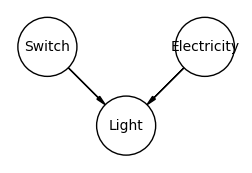

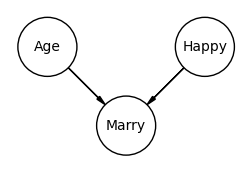

In [5]:
X = "Switch"
Y = "Electricity"
Z = "Light"
G = nx.DiGraph(((X, Z), (Y, Z)))
coordinates = {X: (0, 0), Z: (1, -1), Y: (2, 0)}
draw_PGM(G, coordinates, node_unit=1.5)

X = "Age"
Y = "Happy"
Z = "Marry"
G = nx.DiGraph(((X, Z), (Y, Z)))
coordinates = {X: (0, 0), Z: (1, -1), Y: (2, 0)}
draw_PGM(G, coordinates, node_unit=1.5)

### Code 6.21
Now we're going to look at "collider bias", where conditioning on the common descendent in a DAG (like node B in the graph A -> B <- C), causes a statistical association between A and C, even though there is no causal connection. We can create an example to demonstrate this using the following simulation:

1. Each year, 20 people are born with uniformly distributed happiness values
2. Each year, each person ages one year. Happiness does not change.
3. At age 18, individuals can become married. The odds of marriage are proportional to an individual's happiness.
4. Once married, an individual remains married.
5. After age 65, individuals leave the sample. (the author suggests "they move to Spain", but we know what he means...)

This simulation generates data according to the DAG $H \rightarrow M \leftarrow A$, where $H$ is happiness, $M$ is marriage, and $A$ is age. I'm not entirely sure what the parameters for the marriage probability etc. are, but will try my best.

In [6]:
def sim_happiness(N_years):
    people = deque()
    age = []
    married = []
    happiness = []
    # Update population statistics and take data every year
    for year in tqdm.notebook.tnrange(N_years):
        # 20 new people are born
        for i in range(20):
            h = 4*(i/19 - 0.5)
            person = dict(age=-1, married=False, happiness=h)
            people.append(person)
        # Discard people over 65 from the sample
        while people[0]["age"] > 65:
            people.popleft()
        # Update age/marriage
        for person in people:
            person["age"] += 1
            if (person["age"] >= 18) and (not person["married"]):
                p = 0.06*(person["happiness"] + 2)/4
                person["married"] = np.random.choice((True, False), p=(p, 1-p))
    # Collect data
    for person in people:
        age.append(person["age"])
        married.append(int(person["married"]))
        happiness.append(person["happiness"])
    # Put all data in dataframe
    df = pd.DataFrame(dict(age=age, married=married, happiness=happiness))
    return df

d = sim_happiness(100)
precis({k: d[k].values for k in d.columns})

  0%|          | 0/100 [00:00<?, ?it/s]

,mean,stddev,5.5%,94.5%
age,33.0,19.34,3.0,63.0
married,0.32,0.47,0.0,1.0
happiness,-0.0,1.21,-1.79,1.79


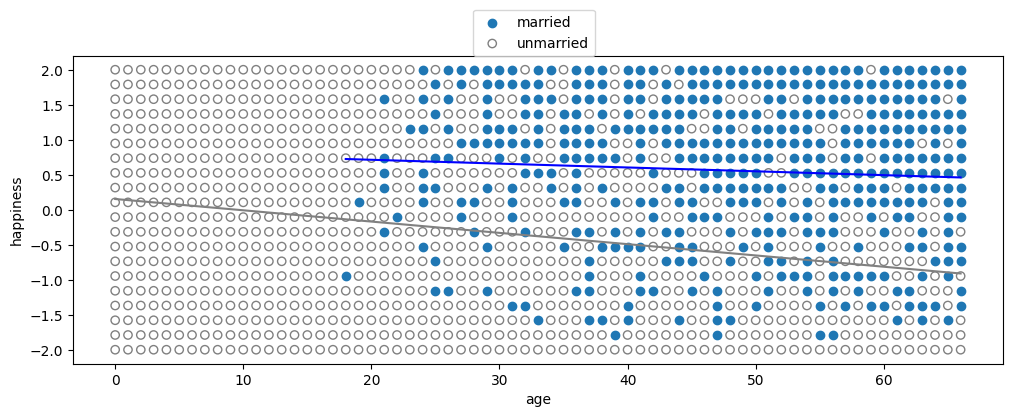

In [7]:
fig = plt.figure(figsize=(12, 4))
x = d["age"].values
y = d["happiness"].values
m = d["married"].astype(bool).values
plt.scatter(x[m], y[m], facecolor="C0", edgecolor="C0", label="married")
plt.scatter(x[~m], y[~m], facecolor="none", edgecolor="gray", label="unmarried")
slope, intercept, _, _, _ = stats.linregress(x[m], y[m])
plt.plot(x[m], slope*x[m] + intercept, color="blue")
slope, intercept, _, _, _ = stats.linregress(x[~m], y[~m])
plt.plot(x[~m], slope*x[~m] + intercept, color="gray")
plt.xlabel("age")
plt.ylabel("happiness")
plt.legend(loc=(0.43, 1))
plt.show()

### Code 6.22 - 6.23
Do a regression on this dataset using the model $\mu_i = \alpha_{\text{M}[i]} + \beta_A A_i$

In [8]:
d2 = d[d["age"] > 17].copy()
d2["A"] = (d2["age"] - 18)/(65-18)

  0%|          | 0/1000 [00:00<?, ?it/s]

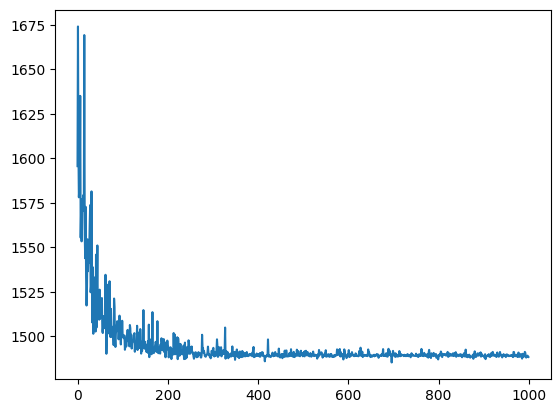

In [9]:
class M6_9(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 1.).expand([2]).to_event(1))
        bA = pyro.sample("bA", Normal(0., 2.))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = a[self.married] + bA*self.A
        with pyro.plate("N"):
            pyro.sample("happiness", Normal(mu, sigma), obs=self.happiness)

m6_9 = M6_9(d2, categoricals=("married",))
loss = m6_9.train(1000)
plt.plot(loss); plt.show()

(1000, 1, 2)
       mean stddev  5.5% 94.5%
bA    -0.68   0.12 -0.87  -0.5
sigma   1.1   0.03  1.05  1.14
a0    -0.19   0.06 -0.29  -0.1
a1     0.95   0.09   0.8   1.1


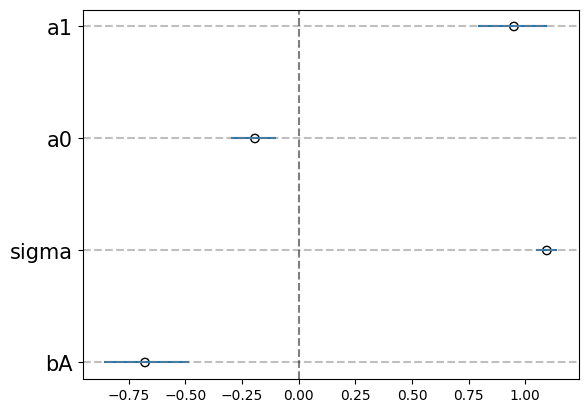

In [10]:
samples = sample_posterior(m6_9, 1000, ("a", "bA", "sigma"))
print(samples["a"].shape)
samples["a0"] = samples["a"].squeeze()[:,0]
samples["a1"] = samples["a"].squeeze()[:,1]
del samples["a"]
print(precis(samples))
plot_intervals(samples, 0.89)


In [11]:
precis(samples)

,mean,stddev,5.5%,94.5%
bA,-0.68,0.12,-0.87,-0.5
sigma,1.1,0.03,1.05,1.14
a0,-0.19,0.06,-0.29,-0.1
a1,0.95,0.09,0.8,1.1


### Code 6.24
The above model is certain that age is negatively correlated with happiness, even though we know from our simulation that it isn't. Now, let's create a new model that doesn't take marriage status into account:

Do a regression on this dataset using the model $\mu_i = \alpha + \beta_A A_i$

  0%|          | 0/1000 [00:00<?, ?it/s]

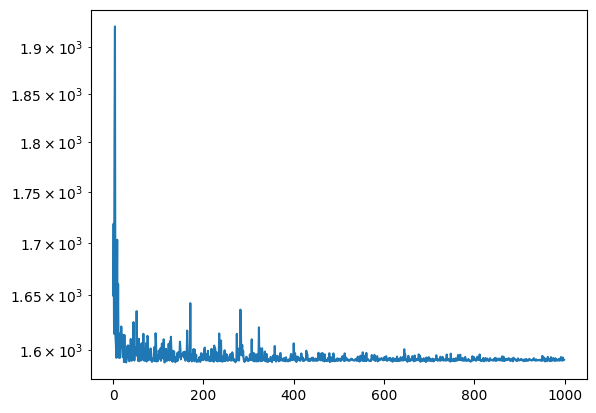

In [12]:
class M6_10(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 1.))
        bA = pyro.sample("bA", Normal(0., 2.))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = a + bA*self.A
        with pyro.plate("N"):
            pyro.sample("happiness", Normal(mu, sigma), obs=self.happiness)
        
m6_10 = M6_10(d2[["A","happiness"]])
loss = m6_10.train(1000)
plt.plot(loss); plt.yscale("log"); plt.show()

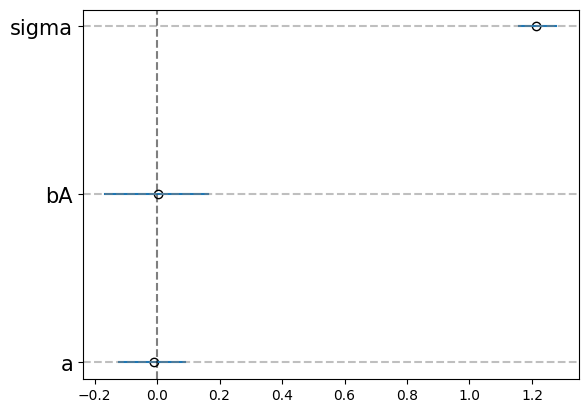

In [13]:
samples = sample_posterior(m6_10, 1000, ("a", "bA", "sigma"))

plot_intervals(samples, 0.89)

In [14]:
df = precis(samples).astype(float).round(2)
df

,mean,stddev,5.5%,94.5%
a,-0.01,0.07,-0.12,0.10
bA,0.00,0.10,-0.16,0.17
sigma,1.21,0.04,1.15,1.28


Now it looks like $\beta_A$ is consistent with zero, so that there is no relationship between age and happiness

### Code 6.25-6.27
Assume we are studying the effect of grandparents $G$ and parents $P$ on the educational achievments of their children $C$. Presumably, $G$ also influences $P$, so we have a DAG like:

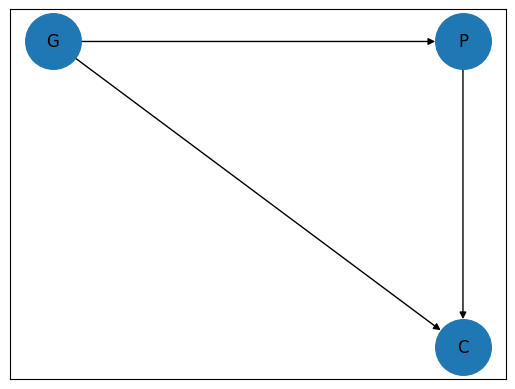

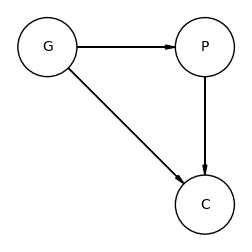

In [15]:
G = nx.DiGraph()
edge_list = (("G", "P"), ("P","C"), ("G", "C"))
G.add_node("G", pos=(0,1))
G.add_node("P", pos=(1,1))
G.add_node("C", pos=(1,0))
for e in edge_list:
    G.add_edge(*e)
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'),  node_size=1600)


coordinates = {"G": (0, 1), "P": (2, 1), "C": (2, -1)}
draw_PGM(G, coordinates, node_unit=1.5)

But what if there is an unobserved factor $U$ that affects both $P$ and $C$? (Like maybe the neighborhood the parents/children live in)

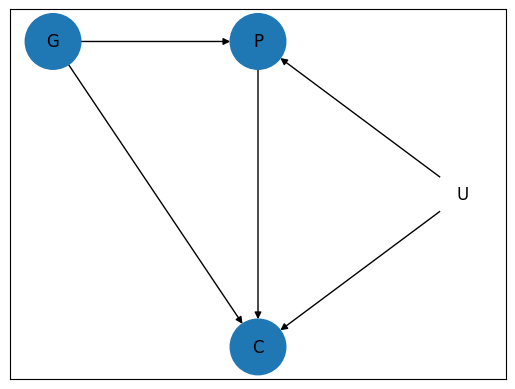

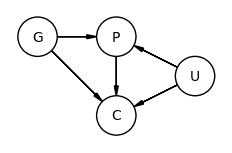

In [16]:
G.add_node("U", color="white", pos=(2, 0.5))
G.add_edge("U", "C")
G.add_edge("U", "P")
col = ["white" if n == "U" else "C0" for n in G.nodes]
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'), node_color=col, with_labels=True, node_size=1600)

coordinates = {"G": (0, 1, True), "P": (1, 1, True), "C": (1, 0, True), "U": (2, 0.5, True)}
draw_PGM(G, coordinates, node_unit=1)

If we condition on $P$, then it will bias inference about $G \rightarrow C$, even if $U$ is never observed. Let's generate some example data to show this effect:

In [17]:
N = 200 # number of grandparent-parent-child triads
b_GP = 1 # direct effect of G on P
b_GC = 0 # direct effect of G on C
b_PC = 1 # direct effect of P on C
b_U = 2 # direct effect of U on P and C

U = 2*Bernoulli(0.5).sample([N]) - 1 #2*stats.bernoulli(p=0.5).rvs(N) - 1
G = Normal(0.0,1.0).sample([N]) #np.random.randn(N)
P = b_GP*G + b_U*U + Normal(0.0,1.0).sample([N]) #np.random.randn(N)
C = b_PC*P + b_GC*G + b_U*U + Normal(0.0,1.0).sample([N]) #np.random.randn(N)

d = pd.DataFrame(dict(C=C.numpy(), P=P.numpy(), G=G.numpy(), U=U.numpy()))
d

,C,P,G,U
0,2.27,1.65,0.15,1.0
1,2.83,0.61,-1.07,1.0
2,3.68,2.21,0.68,1.0
3,-4.47,-2.21,-0.31,-1.0
4,3.96,2.24,0.37,1.0
...,...,...,...,...
195,-3.59,-2.53,-1.32,-1.0
196,-7.17,-5.19,-2.10,-1.0
197,3.00,1.55,-0.93,1.0
198,-2.00,0.94,0.87,-1.0


In [18]:
N = 200 # number of grandparent-parent-child triads
b_GP = 1 # direct effect of G on P
b_GC = 0 # direct effect of G on C
b_PC = 1 # direct effect of P on C
b_U = 2 # direct effect of U on P and C

U = 2*Bernoulli(0.5).sample([N]) - 1
G = Normal(0.0,1.0).sample([N])
P = b_GP*G + b_U*U + Normal(0.0,1.0).sample([N])
C = b_PC*P + b_GC*G + b_U*U + Normal(0.0,1.0).sample([N])


d = pd.DataFrame(dict(C=C.numpy(), P=P.numpy(), G=G.numpy(), U=U.numpy()))
d

,C,P,G,U
0,3.04,1.93,-0.19,1.0
1,-3.75,-0.15,0.16,-1.0
2,7.90,4.54,1.70,1.0
3,-3.20,-1.80,0.36,-1.0
4,3.56,1.68,-0.78,1.0
...,...,...,...,...
195,5.45,2.79,0.42,1.0
196,2.66,1.90,0.10,1.0
197,8.60,6.21,0.70,1.0
198,-4.33,-2.26,-0.32,-1.0


  0%|          | 0/3000 [00:00<?, ?it/s]

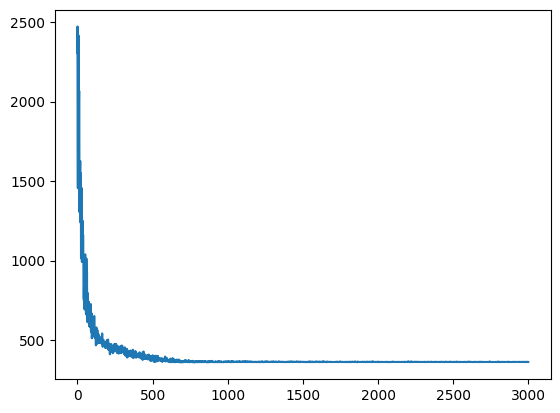

In [19]:
class M6_11(RegressionBase):
    def __call__(self):
        sigma = pyro.sample("sigma", Exponential(1.))
        a = pyro.sample("a", Normal(0., 1.))
        b_PC = pyro.sample("b_PC", Normal(0., 1.))
        b_GC = pyro.sample("b_GC", Normal(0., 1.))
        mu = a + b_PC*self.P + b_GC*self.G
        with pyro.plate("N"):
            pyro.sample("C", Normal(mu, sigma), obs=self.C)
        
m6_11 = M6_11(d[["P", "C", "G"]])
loss = m6_11.train(3000)
plt.plot(loss); plt.show()

       mean stddev  5.5% 94.5%
sigma   1.4   0.07  1.29  1.52
a     -0.02    0.1 -0.17  0.13
b_PC    1.8   0.05  1.73  1.88
b_GC  -0.77   0.11 -0.94  -0.6


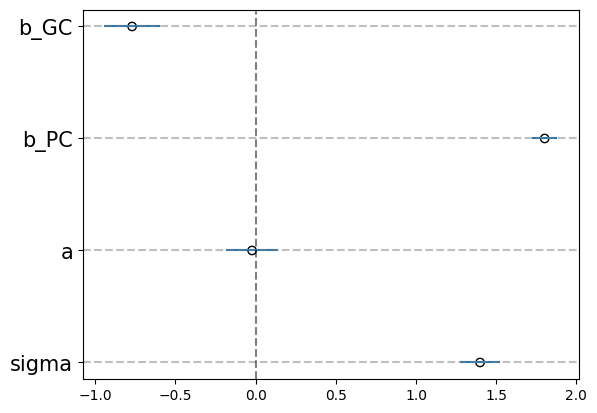

In [20]:
samples = sample_posterior(m6_11, 10000, ("sigma", "a", "b_PC", "b_GC"))
print(precis(samples))
plot_intervals(samples, 0.89)

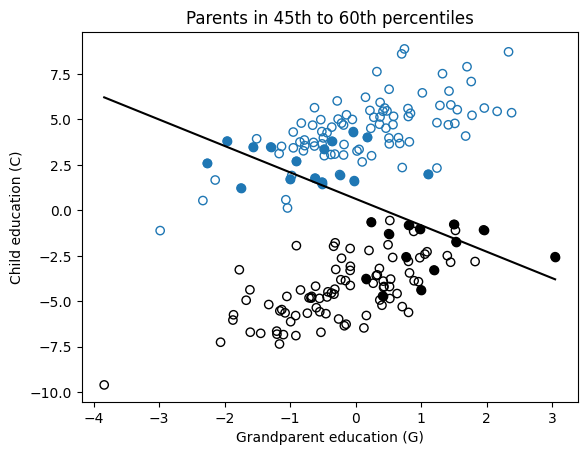

In [21]:
# Plot the unconditional distributions of G and C
mask1 = d["U"] == 1
plt.scatter(d.loc[mask1, "G"], d.loc[mask1, "C"], facecolor="none", edgecolor="C0")
plt.scatter(d.loc[~mask1, "G"], d.loc[~mask1, "C"], facecolor="none", color="black")
# Plot the distributions of G and C conditional on P being between the 45-60th percentiles
mask2 = d["P"].between(*np.quantile(d["P"], (0.45, 0.60)))
plt.scatter(d.loc[mask1 & mask2, "G"], d.loc[mask1 & mask2, "C"], color="C0")
plt.scatter(d.loc[(~mask1) & mask2, "G"], d.loc[(~mask1) & mask2, "C"], color="black")
# Draw regression line through the conditional distribution
x = d.loc[mask2, "G"].values
y = d.loc[mask2, "C"].values
m, b, _, _, _ = stats.linregress(x, y)
x = np.linspace(d["G"].min(), d["G"].max())
y = m*x + b
plt.plot(x, y, color="black")
plt.xlabel("Grandparent education (G)")
plt.ylabel("Child education (C)")
plt.title("Parents in 45th to 60th percentiles")
plt.savefig('./figure/grandchildren_0_45_0_60.png')
plt.show()

### Code 6.28
The only way we can alleviate the above problem is by controlling for $U$:

  0%|          | 0/3000 [00:00<?, ?it/s]

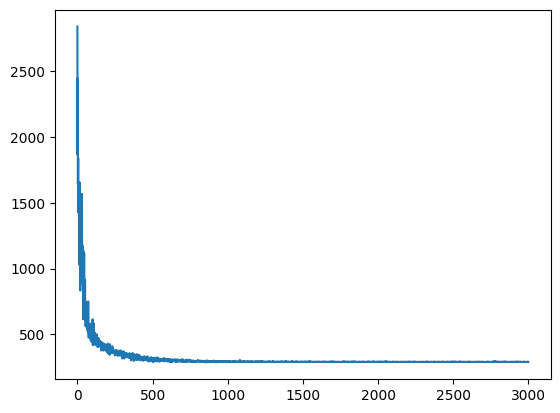

In [22]:
class M6_12(RegressionBase):
    def __call__(self):
        a = pyro.sample("a", Normal(0., 1.))
        b_PC = pyro.sample("b_PC", Normal(0., 1.))
        b_GC = pyro.sample("b_GC", Normal(0., 1.))
        b_U = pyro.sample("b_U", Normal(0., 1.))
        sigma = pyro.sample("sigma", Exponential(1.))
        mu = a + b_PC*self.P + b_GC*self.G + b_U*self.U
        with pyro.plate("N"):
            pyro.sample("C", Normal(mu, sigma), obs=self.C)
        
m6_12 = M6_12(d)
loss = m6_12.train(3000)
plt.plot(loss); plt.show()

       mean stddev  5.5% 94.5%
a     -0.03   0.07 -0.14  0.07
b_PC   0.96   0.06  0.87  1.05
b_GC    0.1    0.1 -0.05  0.26
b_U    2.19   0.13  1.98   2.4
sigma  0.97   0.05  0.89  1.05


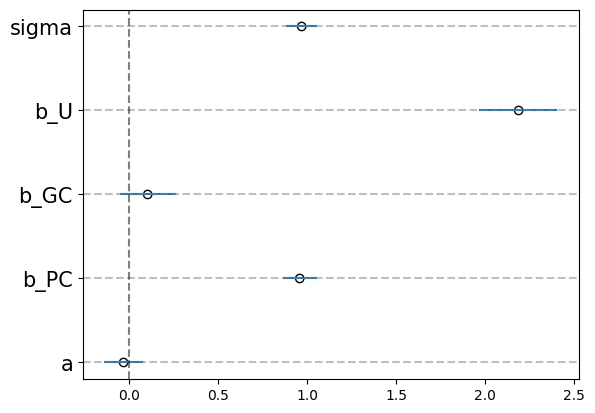

In [23]:
samples = sample_posterior(m6_12, 10000)
del samples["C"]
print(precis(samples))
plot_intervals(samples, 0.89)

### Code 6.29 - 6.30
Let's consider the following DAG (where $U$ is unobserved):

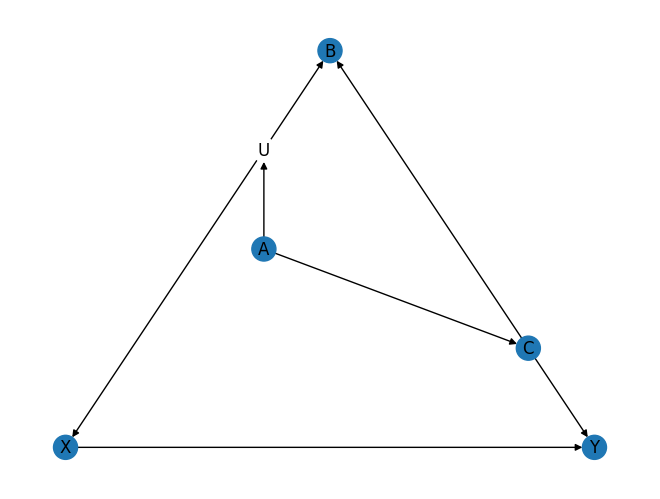

In [24]:
G = nx.DiGraph((("X", "Y"), ("U", "X"), ("U","B"), ("A","U"), ("A", "C"), ("C", "B"), ("C", "Y")))
G.nodes["U"]["color"] = "white"
color = [v.get("color", "C0") for k, v in G.nodes.items()]
nx.draw_planar(G, with_labels=True, node_color=color)
plt.show()

![Screenshot from 2024-07-10 21-39-55.png](<attachment:Screenshot from 2024-07-10 21-39-55.png>)
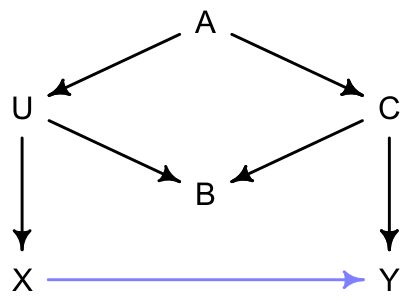

We want to infer the causal effect of $X$ on $Y$, but we can see that there are some counfounding paths (backdoors) that could prevent inference. Specifically, there are two paths (1) $X \leftarrow U \leftarrow A \rightarrow C \rightarrow Y$ and (2) $X \leftarrow U \rightarrow B \leftarrow C \rightarrow Y$. We can see that (2) is actually already blocked because of the collider on $B$, but (1) is currently unblocked. This means that we would need to condition on either $B$ or $C$ to close off the backdoor. Conditioning on $C$ is probably better since it is closer to $Y$ and so we wouldn't have to worry about the effect of uncertainty in $B$ influencing things.

Now consider the waffle house example from the very beginning of the chapter. The DAG representing the causal influences here is

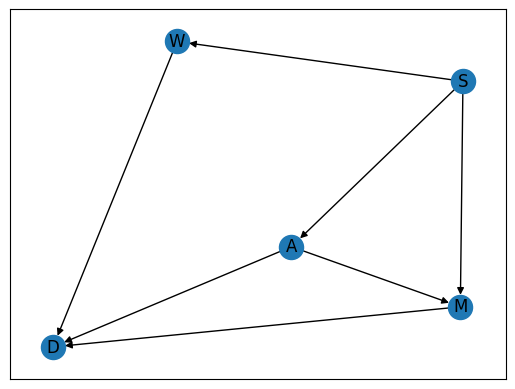

In [25]:
dag_6_2 = nx.DiGraph((("S", "W"), ("W", "D"), ("S", "M"), ("M", "D"), ("S", "A"), ("A", "M"), ("A", "D")))
nx.draw_networkx(dag_6_2, with_labels=True)
plt.show()

![Screenshot from 2024-07-10 21-55-49.png](<attachment:Screenshot from 2024-07-10 21-55-49.png>)
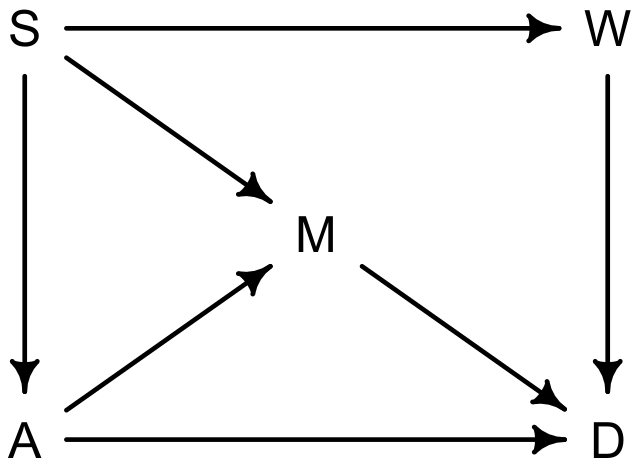

In this graph, $S$ is whether or not a state is "southern", $A$ is median age at marriage, $W$ is the number of Waffle Houses, $M$ is the marriage rate, and $D$ is the divorce rate. This graph assumes that southern states have lower ages of marriage ($S \rightarrow A$), higher rates of marriage both directly ($S \rightarrow M$), and mediated through age of marriage ($S \rightarrow A \rightarrow M$), as well as more Waffle Houses ($S \rightarrow W$). Age of marriage and marriage rate both influence divorce. There are three open backdoor paths from $W$ to $D$:
$$
W \leftarrow S \rightarrow A \rightarrow D \\
W \leftarrow S \rightarrow A \rightarrow M \rightarrow D \\
W \leftarrow S \rightarrow M \rightarrow D
$$
There is one other backdoor path ($W \leftarrow S \rightarrow M \leftarrow A \rightarrow D$), but it is already closed because of the collider on $M$. So in order to close these backdoor paths, our options are to condition on either $S$ or $\{A, M\}$ (conditioning on $A$ by itself is not enough, because the $W \leftarrow S \rightarrow M \rightarrow D$ path is still open). It is probably best to just condition on $S$ because it will keep the model simpler. Why add two predictors when you only need one?

### Code 6.30

In [26]:
dag_6_2 = nx.DiGraph()
dag_6_2.add_edges_from(
    [("S", "A"), ("A", "D"), ("S", "M"), ("M", "D"), ("S", "W"), ("W", "D"), ("A", "M")])

print(find_adjustment_sets(dag_6_2))

[{'S'}, {'M', 'A'}]


### Code 6.31
Is there any way we can test whether this DAG is correct? Well... no, because there could always be unobserved confounds that we haven't thought of. But we can test and see whether the DAG is _incorrect_ using conditional independencies implied by the graph.

In [27]:
print(conditional_independencies(dag_6_2))

[('A', 'W', 'S'), ('M', 'W', 'S')]


In [28]:
conditional_independencies_v2(dag_6_2)

defaultdict(list,
            {('A', 'W'): [{'S'}],
             ('D', 'S'): [{'A', 'M', 'W'}],
             ('M', 'W'): [{'S'}]})

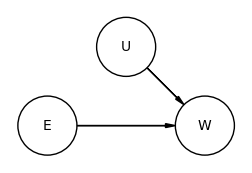

In [29]:
G = nx.DiGraph((("E", "W"), ("U","W")))

coordinates = {"E": (0, 0), "U": (1, 1), "W": (2, 0)}
draw_PGM(G, coordinates, node_unit=1.5)